# Product Recognition on Store Shelves

### Marco Scaramuzzi 
- Student ID: 0001057167
- email: marco.scaramuzzi@studio.unibo.it

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify boxes of cereals of different brands from one picture of a store shelf. For each type of product displayed in the shelf the system should report:

1. Number of instances.
2. Dimension of each instance (width and height of the bounding box that enclose them in pixel).

#### Train on model image: {0.png, 1.png, 11.png, 19.png, 24.png, 25.png, 26.png}
#### Test on scene image: {e1.png, e2.png, e3.png, e4.png, e5.png}


In [3]:
#Import required modules
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
import cv2
import os
from typing import Tuple
from collections import defaultdict
from glob import glob

# Only for jupyter notebook visualization
%matplotlib inline

from numpy.typing import NDArray
from typing import Callable, Dict, List
from image_utils import *

%load_ext autoreload
%autoreload 2

In [4]:
MODEL_REFERENCE_NUM = [0,1,11,19,24,25,26]
DISPLAY_NAME = ['NES_CK_MLK','CHC_KRV_BLUE', 'CHC_KRV_ORANGE', 'CNTR_CRISP', 'FIT_PINK', 'POPS_RED', 'NES_DUO']
file_to_model_mapping = dict(zip(MODEL_REFERENCE_NUM, DISPLAY_NAME))

# 1. Data inspection

#### Loading and inspecting images

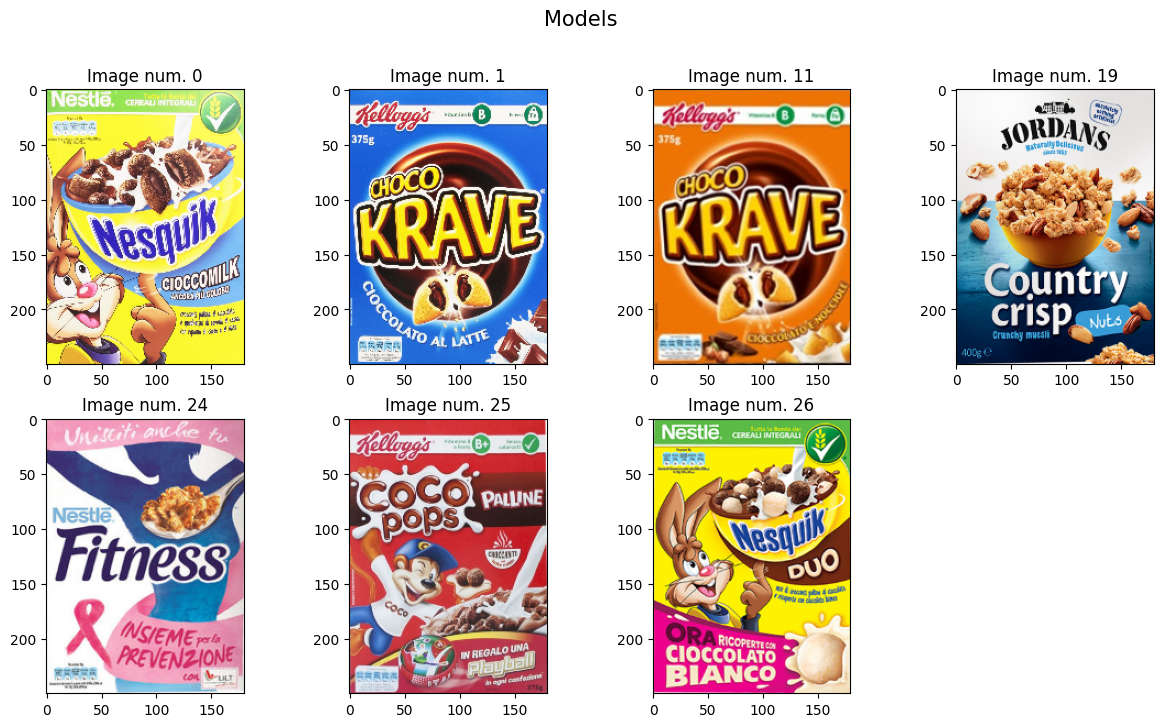

In [5]:
query_images = load_images(base_path='models', step_directory='step_A', image_indices=MODEL_REFERENCE_NUM)
show_images(query_images, n_cols=4, title='Models')

#### Loading scene images inspecting them

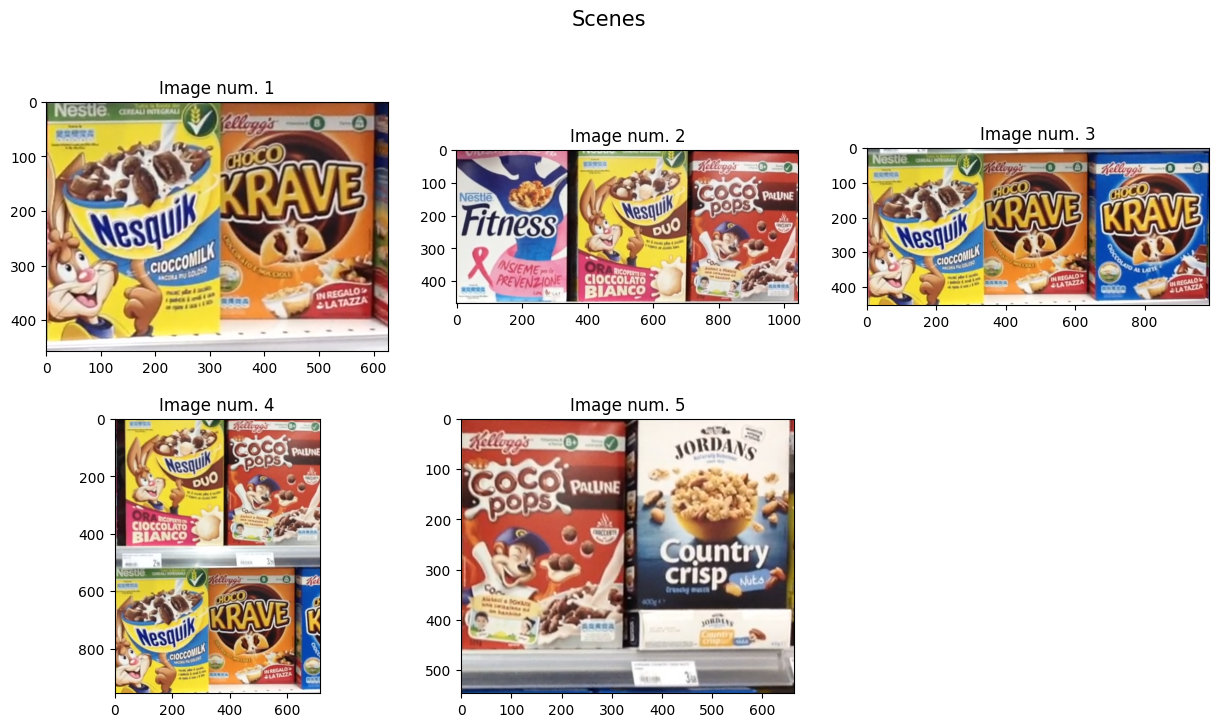

In [6]:
train_images = load_images(base_path='scenes', step_directory='step_A')
show_images(train_images, n_cols=3, title='Scenes')

## 2. Keypoints detection and description

In [7]:
def create_channel_dict(img: NDArray[np.uint8]) -> dict[str, NDArray[np.uint8]]:
    """Return a dictionary which contains the RGB channels

    Args:
        img (NDArray[np.uint8]): Input image in RGB format

    Returns:
        dict[str, NDArray[np.uint8]]: Dictionary containing the R, G, and B channels
    """
    r_channel, g_channel, b_channel = cv2.split(img)
    return {
        "R": r_channel,
        "G": g_channel,
        "B": b_channel
    }

def extract_features_dict(
    images: dict[int, NDArray[np.uint8]],
    detector: cv2.Feature2D
        ) -> tuple[dict[int, dict[str, list[cv2.KeyPoint]]], dict[int, dict[str, NDArray[np.float32]]]]:

    """
    Extract keypoints and descriptors for each image and its RGB channels.

    This function processes a collection of images, extracting feature keypoints
    and descriptors for each image's red, green, and blue (RGB) channels using
    a specified OpenCV feature detector (e.g., SIFT, ORB). The extracted features
    are organized into dictionaries for easy access and analysis.

    Args:
        images (dict[int, NDArray[np.uint8]]):
            A dictionary where the keys are image IDs (integers) and the values
            are the corresponding images represented as NumPy arrays in uint8 format.
        detector (cv2.Feature2D):
            An OpenCV Feature2D object responsible for detecting keypoints and
            computing descriptors (e.g., cv2.SIFT_create()).

    Returns:
        tuple[dict[int, dict[str, list[cv2.KeyPoint]]], dict[int, dict[str, NDArray[np.float32]]]]:
            A tuple containing two dictionaries:

            - keypoints_dict: A dictionary mapping each image ID to another dictionary
              containing the keypoints for the RGB channels. The structure is:
              {image_id: {'R': [keypoints], 'G': [keypoints], 'B': [keypoints]}}.

            - descriptors_dict: A dictionary mapping each image ID to another dictionary
              containing the descriptors for the RGB channels. The structure is:
              {image_id: {'R': descriptors, 'G': descriptors, 'B': descriptors}}.

    Example:
        images = {
            1: cv2.imread("image1.jpg"),
            2: cv2.imread("image2.jpg")
        }
        detector = cv2.SIFT_create()
        keypoints_dict, descriptors_dict = extract_features_dict(images, detector)

    Notes:
        - The function assumes that the input images are in RGB format.
        - The `create_channel_dict` helper function is used to split each image
          into its RGB channels.
        - The `detector.detectAndCompute` method is called for each channel to
          extract the keypoints and descriptors.
    """
    keypoints_dict = {}
    descriptors_dict = {}

    for img_id, img in images.items():
        channels = create_channel_dict(img)

        keypoints_color_dict = {}
        descriptors_color_dict = {}

        for color_name, channel_img in channels.items():
            kp_color, des_color = detector.detectAndCompute(channel_img, None)
            keypoints_color_dict[color_name] = kp_color
            descriptors_color_dict[color_name] = des_color

        keypoints_dict[img_id] = keypoints_color_dict
        descriptors_dict[img_id] = descriptors_color_dict

    return keypoints_dict, descriptors_dict

For clarity the structure of the keypoints and descriptors dictionary is shown, but it will be computed inside the functions  

In [8]:
# Instantiate dictionaries containing keypoints for query and train images
sift = cv2.SIFT_create()
kp_query_dict, des_query_dict = extract_features_dict(query_images, sift)
kp_train_dict, des_train_dict = extract_features_dict(train_images, sift)

In [9]:
# The dictionaries keys are the model/scene number and they contain the keypoints/descriptors as values
# { id: { 'red': kp, 'green': kp, 'blue': kp } }
print('\n- Model number keys: ', kp_query_dict.keys())
print('\n- Inspecting that the key structure is correct for model 0: ',kp_query_dict[0].keys())


- Model number keys:  dict_keys([0, 1, 11, 19, 24, 25, 26])

- Inspecting that the key structure is correct for model 0:  dict_keys(['R', 'G', 'B'])


## 3. Feature matching

In [10]:
def initialize_flann():
    """
    Initializes the FLANN matcher with default parameters.

    Returns:
        cv2.FlannBasedMatcher: Instance of the FLANN Matcher.
    """
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    return cv2.FlannBasedMatcher(index_params, search_params)

In [11]:
def filter_matches(matches: list[list[cv2.DMatch]]) -> list[cv2.DMatch]:

    """
    Filters false positives using Lowe's ratio test.

    This function accepts a match only if:
        - The distance of the best match (m) is significantly smaller than the distance of the second-best match (n).
        - Specifically, m.distance < 0.7 * n.distance.

    Parameters:
        matches (list[list[cv2.DMatch]]): List of pairs (k=2) obtained from knnMatch(..., k=2).

    Returns:
        list[cv2.DMatch]: List of accepted matches that pass the ratio test.
    """

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
    return good_matches

In [217]:
def compute_matches_dict_single(
    des_query_dict_single: Dict[str, NDArray[np.float32]],
    des_train_dict_single: Dict[str, NDArray[np.float32]],
    flann_init_func: Callable[[], cv2.FlannBasedMatcher],
    filter_func: Callable[[List[List[cv2.DMatch]]], List[cv2.DMatch]]
    ) -> Dict[str, List[cv2.DMatch]]:

    """
    Performs matching (k=2) and filtering (ratio test) between the descriptors
    of the 'model_id' and those of the 'scene_id', channel by channel ('R', 'G', 'B').

    Returns a dictionary:
        { 'R': [...], 'G': [...], 'B': [...] } containing the "good" matches for each channel.

    Parameters:
        descriptors_query_dict:
            {
              model_id1: { 'R': des_R, 'G': des_G, 'B': des_B },
              model_id2: { ... }
            }
        descriptors_train_dict:
            {
              scene_id1: { 'R': des_R, 'G': des_G, 'B': des_B },
              scene_id2: { ... }
            }

        model_id (int): Identifier of the model (query) to match.
        scene_id (int): Identifier of the scene (train) to match against.
        flann_init_func (Callable): Function that creates and returns a new FLANNBasedMatcher.
        filter_func (Callable): Function that filters the k=2 matches (e.g., ratio test).

    Returns:
        good_matches_channels (Dict[str, List[cv2.DMatch]]):
            A dictionary containing the good matches for each channel:
            { 'R': [...], 'G': [...], 'B': [...] }
    """

    # Output dictionary for the "good" matches for each channel.
    good_matches_channels = {}

    # Iterate over each channel ('R', 'G', 'B').
    for color_name, des_query in des_query_dict_single.items():
        # Retrieve the corresponding descriptors in the scene.
        des_train = des_train_dict_single[color_name]

        # Initialize the FLANN matcher.
        flann_matcher = flann_init_func()

        # Perform knnMatch with k=2.
        matches = flann_matcher.knnMatch(des_query, des_train, k=2)

        # Apply the ratio test or other filtering.
        good = filter_func(matches)

        good_matches_channels[color_name] = good

    return good_matches_channels


In [218]:
def compute_homography(
    kp_query_dict_single: Dict[str, List[cv2.KeyPoint]],
    kp_train_dict_single: Dict[str, List[cv2.KeyPoint]],
    good_matches_channels: Dict[str, List[cv2.DMatch]]) -> NDArray[np.float64]:

    """
    Computes a homography matrix using keypoints and matches for each color channel.

    Args:
        kp_query_dict_single (Dict[str, List[cv2.KeyPoint]]): Dictionary of keypoints for the query image,
            with keys ['R', 'G', 'B'] corresponding to color channels.
        kp_train_dict_single (Dict[str, List[cv2.KeyPoint]]): Dictionary of keypoints for the train image,
            with keys ['R', 'G', 'B'] corresponding to color channels.
        good_matches_channels (Dict[str, List[cv2.DMatch]]): Dictionary of good matches for each color channel.

    Returns:
        NDArray[np.float64]: Homography matrix computed using RANSAC.
    """

    src_array = np.array([])
    dst_array = np.array([])

    for color in kp_train_dict_single.keys():
        src_pts = np.float32([kp_query_dict_single[color][m.queryIdx].pt for m in good_matches_channels[color]]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train_dict_single[color][m.trainIdx].pt for m in good_matches_channels[color]]).reshape(-1, 1, 2)

        src_array = np.vstack([src_array, src_pts]) if src_array.size else src_pts
        dst_array = np.vstack([dst_array, dst_pts]) if dst_array.size else dst_pts

    M, _ = cv2.findHomography(src_array, dst_array, cv2.RANSAC, 5.0)
    return M

In [ ]:
def object_retrieve(flann_init_func: Callable,
                    filter_func: Callable,
                    img_query,
                    kp_query_dict_single: dict[str, NDArray[np.float32]],
                    des_query_dict_single: dict[str, NDArray[np.float32]],
                    kp_train_dict_single: dict[str, NDArray[np.float32]],
                    des_train_dict_single: dict[str, NDArray[np.float32]],
                    min_match_count_single_channel: int):
    """
    Esegue il matching, la stima dell'omografia e i controlli (inlier, validazione omografia e colore)
    e disegna la bounding box se l'oggetto viene rilevato correttamente.
    """
    # 1. Retrieve matches
    good_matches_channels = compute_matches_dict_single(
        des_query_dict_single,
        des_train_dict_single,
        flann_init_func,
        filter_func)

    num_r_matches, num_g_matches, num_b_matches = len(good_matches_channels['R']), len(good_matches_channels['G']), len(good_matches_channels['B'])
    num_matches_all_channels = num_r_matches + num_g_matches + num_b_matches

    # 2. If num of matches exceeds the threshold compute the homography
    # Threshold is obtained as the min_match_count per single channel times the number of channels
    if num_matches_all_channels > min_match_count_single_channel * len(good_matches_channels):
        homography = compute_homography(
            kp_query_dict_single,
            kp_train_dict_single,
            good_matches_channels)

        height, width = img_query.shape[:2]

        # Corners of the query image (model)
        pts = np.float32([
            [0, 0],             # top-left corner
            [0, height - 1],    # bottom-left corner
            [width - 1, height - 1],  # bottom-right corner
            [width - 1, 0]      # top-right corner
        ]).reshape(-1, 1, 2)

        # Projecting the corners into the train image
        dst = cv2.perspectiveTransform(pts, homography)

        # Calculate box dimensions and center
        box_width = np.linalg.norm(dst[1][0] - dst[2][0]) #  Distance between bottom-left and bottom-right
        box_height = np.linalg.norm(dst[0][0] - dst[1][0])   # Distance between top-left and bottom-left
        box_center = np.mean(dst, axis=0).flatten()  # Average of all corners

        return box_width, box_height, box_center, dst

    # Return None if no valid matches are found
    return None, None, None, None

def process_and_draw_instances(instances_info: list, query_images: dict[str, any], img_train: np.ndarray) -> np.ndarray:
    """
    Process and draw bounding boxes for detected instances in the train image.

    Args:
        instances_info (list): List of detected instances information.
        query_images (dict): Dictionary of query images.
        img_train (np.ndarray): Train image to draw bounding boxes on.

    Returns:
        np.ndarray: The train image with drawn bounding boxes.
    """
    for instances_info_query, query_name in zip(instances_info, query_images.keys()):
        inst_num = 0
        found_instances = len(instances_info_query)
        print(f"Product {query_name} - {found_instances} instance(s) found:")

        for instance_info in instances_info_query:
            # Draw the bounding box on a copy of the image to preserve the original
            img_train_bounding = cv2.polylines(
                img_train.copy(),
                pts=[np.int32(instance_info[3])],
                isClosed=True,
                color=(0, 255, 0),
                thickness=4,
                lineType=cv2.LINE_AA
            )

            # Printing information
            box_width = round(instance_info[0])
            box_height = round(instance_info[1])
            box_center = instance_info[2]
            inst_num += 1
            print(f"\tInstance {inst_num} {{position: ({round(box_center[0])}, {round(box_center[1])}), width: {box_width}px, height: {box_height}px}}")

    print()
    return img_train_bounding



def main(min_count, query_images, train_images) -> None:
    """
    Iterate over each scene and model to perform object detection and compute bounding boxes.

    This function extracts features from both the query (model) and train (scene) images, then for each scene,
    it matches each model against the scene using the object_retrieve function. If a match is successful based on
    the minimum match threshold (min_count per channel), it collects the detection details. Finally, it draws bounding
    boxes on the train image and displays the results.

    Args:
        min_count (int): Minimum number of matches required per channel to consider a valid detection.
        query_images (dict[int, np.ndarray]): Dictionary mapping model identifiers to their corresponding
            query image arrays.
        train_images (dict[int, np.ndarray]): Dictionary mapping scene identifiers to their corresponding
            train image arrays.

    Returns:
        None
    """
    # Extract features for query and train images
    kp_query_dict_full, des_query_dict_full = extract_features_dict(query_images, sift)
    kp_train_dict_full, des_train_dict_full = extract_features_dict(train_images, sift)

    separator = '*****'

    for scene_id in train_images.keys():
        boxes_info = []  # List of lists of tuples: (box_center, box_width, box_height, dst)
        print(f'🖼️ Analysis of scene: {scene_id}\n')

        img_train = train_images[scene_id]
        kp_train_dict_single, des_train_dict_single = kp_train_dict_full[scene_id], des_train_dict_full[scene_id]

        for model_id in query_images.keys():
            instances_single_model = []  # Instances for the current model in the scene
            img_query = query_images[model_id]

            kp_query_dict_single, des_query_dict_single = kp_query_dict_full[model_id], des_query_dict_full[model_id]

            box_width, box_height, box_center, dst = object_retrieve(
                initialize_flann,
                filter_matches,
                img_query,
                kp_query_dict_single,
                des_query_dict_single,
                kp_train_dict_single,
                des_train_dict_single,
                min_match_count_single_channel=min_count
            )

            if dst is not None:  # Process only when the object is found in the scene
                instance_info = (box_center, box_width, box_height, dst)
                instances_single_model.append(instance_info)

            boxes_info.append(instances_single_model)

        # Draw detected instances and print information
        img_train_bounding = process_and_draw_instances(boxes_info, query_images, img_train)

        plt.figure(figsize=(10, 6), dpi=100)
        plt.imshow(img_train_bounding)
        plt.title(f'Found boxes for scene {scene_id}')
        plt.show()
        print(f'🔬 Completed analysis of scene: {scene_id}\n')
        print(f"{separator*20}\n")


🖼️ Analysis of scene: 1

Product 0 - 1 instance(s) found:
	Instance 1 {position: (162,215), width: 309px, height: 437px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
	Instance 1 {position: (443,169), width: 302px, height: 394px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:



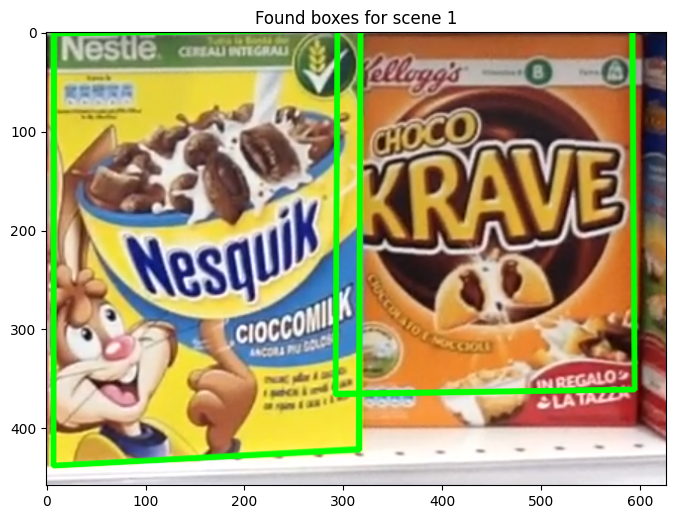

🔬 Completed analysis of scene: 1

****************************************************************************************************

🖼️ Analysis of scene: 2

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 1 instance(s) found:
	Instance 1 {position: (167,219), width: 334px, height: 491px}
Product 25 - 1 instance(s) found:
	Instance 1 {position: (879,233), width: 315px, height: 445px}
Product 26 - 1 instance(s) found:
	Instance 1 {position: (538,218), width: 329px, height: 490px}



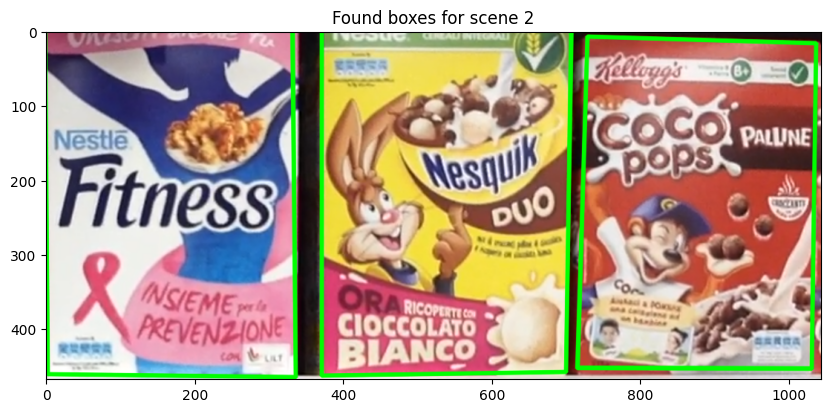

🔬 Completed analysis of scene: 2

****************************************************************************************************

🖼️ Analysis of scene: 3

Product 0 - 1 instance(s) found:
	Instance 1 {position: (170,236), width: 323px, height: 443px}
Product 1 - 1 instance(s) found:
	Instance 1 {position: (818,191), width: 303px, height: 409px}
Product 11 - 1 instance(s) found:
	Instance 1 {position: (475,187), width: 304px, height: 398px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:



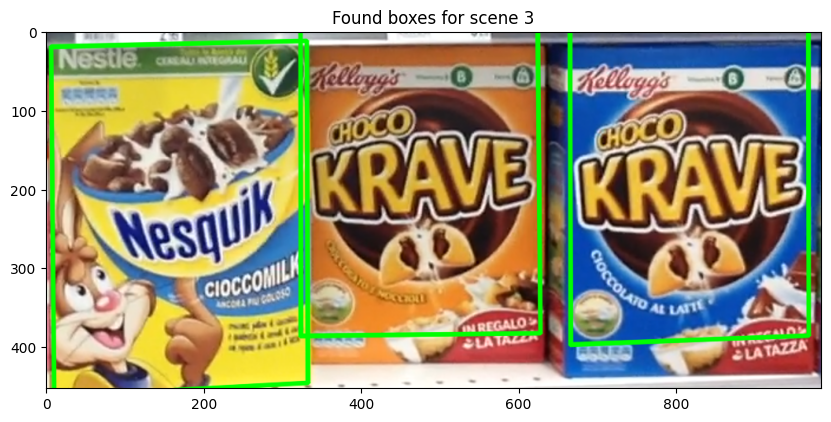

🔬 Completed analysis of scene: 3

****************************************************************************************************

🖼️ Analysis of scene: 4

Product 0 - 1 instance(s) found:
	Instance 1 {position: (159,739), width: 324px, height: 444px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
	Instance 1 {position: (464,690), width: 303px, height: 396px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
	Instance 1 {position: (555,209), width: 325px, height: 448px}
Product 26 - 1 instance(s) found:
	Instance 1 {position: (205,195), width: 337px, height: 498px}



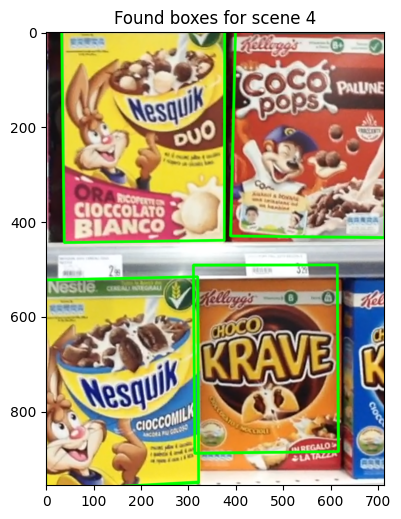

🔬 Completed analysis of scene: 4

****************************************************************************************************

🖼️ Analysis of scene: 5

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 1 instance(s) found:
	Instance 1 {position: (504,190), width: 296px, height: 385px}
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
	Instance 1 {position: (161,227), width: 320px, height: 441px}
Product 26 - 0 instance(s) found:



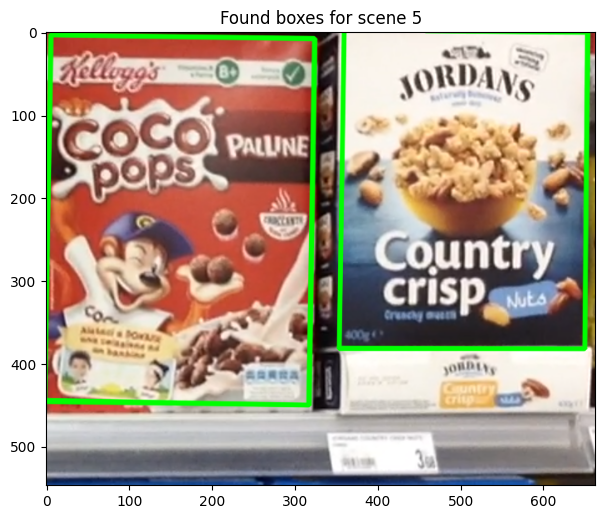

🔬 Completed analysis of scene: 5

****************************************************************************************************



In [222]:
main(min_count=75, query_images=query_images, train_images=train_images)